# **0. Imports**

## 0.1. Libraries

In [1]:
# data manipulation
import pandas as pd
from inflection import underscore
import numpy as np
import psycopg2 as pg

# data visualization
from matplotlib import pyplot as plt
import seaborn as sns

# data balancing
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# preprocessing
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

# feature selection
from sklearn.ensemble import ExtraTreesClassifier
from boruta import BorutaPy

# machine learning
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve, plot_calibration_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier

# hyperparameters fine-tuning
import mlflow
from hyperopt import STATUS_OK, fmin, tpe, hp, Trials
from hyperopt.pyll import scope

# calibration
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

# other
from typing import Protocol, Optional, Dict, Any
import os
from sys import path
path.append('../')
import joblib
from IPython.display import Image
from src.mytoolbox.useful_functions import *
jupyter_settings(filterwarnings=True)

Jupyter settings set.


## 0.2. Helper functions

In [2]:
class SklearnModel(Protocol):
    def fit(self, X, y): ...
    def predict_proba(self, X): ...

In [3]:
def train_model(
    estimator: SklearnModel,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    X_val: pd.DataFrame,
    y_val: pd.DataFrame,
    figsize: Optional[tuple]=(20, 6)
) -> float:
    '''
    train and evaluate machine learning algorithm without cross-validation.

    :param estimators: estimator object that implement 'fit' and 'predict_proba'.
    :param X_train: the data to fit in training step.
    :param y_train: the target variable to try to predict related to the train data.
    :param X_val: the data to fit in the validation step.
    :param y_val: the target variable to try to predict related to the validation data.
    :param figsize: width and height from the figure respectively.
    :return: the probability of the sample for each class in the model. 
    '''
    # instantiate and fit the model
    clf = estimator.fit(X_train, y_train)

    # predict
    p_hat = clf.predict_proba(X_val)

    # plot settings
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    (ax1, ax2) = ax

    # plot cumulative gain
    plot_cumulative_gain(y_val, p_hat, ax=ax1);

    # plot lift curve
    plot_lift_curve(y_val, p_hat, ax=ax2);
    
    return p_hat

In [4]:
def precision_at_k(
    data: pd.DataFrame,
    p_hat: np.ndarray,
    k: Optional[int]=1_000
) -> pd.DataFrame:
    '''
    calculates the precision at any k.
    (# of recommended items at k that are relevant) / (# of recommended items at k)
    
    :param data: the entire data to evaluate.
    :param p_hat: the probability of the sample for each class in the model.
    :param k: number of most likely outcomes considered to find the correct label.
    :returns pandas dataframe with k rows sorted by precision at its specific k.
    '''
    # create score column
    data['score'] = p_hat[:, 1].tolist()
    data = data.sort_values(by='score', ascending=False)

    # reset index
    data = data.reset_index(drop=True)
    
    # ranking
    data['ranking'] = data.index + 1
    
    # create precision at k column
    data['precision_at_k'] = np.round(data['response'].cumsum() / data['ranking'], 4)
    
    return data.loc[k, 'precision_at_k']


def recall_at_k(
    data: pd.DataFrame,
    p_hat: np.ndarray,
    k: Optional[int]=1_000
) -> pd.DataFrame:
    '''
    calculates the recall at any k.
    (# of recommended items at k that are relevant) / (total # of relevant items)

    :param data: the entire data to evaluate.
    :param p_hat: the probability of the sample for each class in the model.
    :param k: number of most likely outcomes considered to find the correct label.
    :returns pandas dataframe with k rows sorted by recall at its specific k.
    '''
    # create score column
    data['score'] = p_hat[:, 1].tolist()
    data = data.sort_values(by='score', ascending=False)

    # reset index
    data = data.reset_index(drop=True)
    
    # ranking
    data['ranking'] = data.index + 1
    
    # create recall at k column
    data['recall_at_k'] = np.round(data['response'].cumsum() / data['response'].sum(), 4)
    
    return data.loc[k, 'recall_at_k']

In [5]:
def cross_validation(
    estimators: SklearnModel,
    X: pd.DataFrame,
    y: pd.DataFrame,
    n_splits: Optional[int]=5,
    shuffle: Optional[bool]=False,
    verbose: Optional[bool]=False
) -> pd.DataFrame:
    '''
    evaluate metric(s) by cross-validation.
    
    :param estimators: list of estimators, objects that implement 'fit' and 'predict_proba'.
    :param X: the data to fit.
    :param y: the target variable to try to predict.
    :param n_splits: number of iterations.
    :param suffle: whether to shuffle training data before taking prefixes of it based on``train_sizes``.
    :param verbose: the verbosity level.
    :returns dataframe with the models and their respective performance
    '''
    # define a counter
    counter = 1

    # define lists to store the results
    precision_at_k_list, recall_at_k_list = [], []

    # create result dataframe
    df_cv_results = pd.DataFrame()

    skf = ms.StratifiedKFold(n_splits=n_splits, shuffle=shuffle)
    for estimator in estimators:
        for train_ix, val_ix in skf.split(X, y):
            # split data into train and validation
            X_train, y_train = X.iloc[train_ix], y.iloc[train_ix]
            X_val, y_val = X.iloc[val_ix], y.iloc[val_ix]

            # fit model
            estimator.fit(X_train, y_train)

            # predict probability
            p_hat = estimator.predict_proba(X_val)

            # prepare data
            df = X_val.copy()
            df['response'] = y_val.astype(int).copy()

            # define K
            K = np.floor((1/2) * (y_val.shape[0]))

            # calculate metrics
            patk = precision_at_k(df, p_hat, K)
            ratk = recall_at_k(df, p_hat, K)

            # store metrics
            precision_at_k_list.append(patk)
            recall_at_k_list.append(ratk)

            # check verbosity
            if verbose:
                print(f'fold={counter}, precision_at_{K}={patk}, recall_at_{K}={ratk}')
                counter += 1

        # result dataframe
        df = pd.DataFrame({
            'Model': str(estimator).split('(')[0],
            'Precision@K': f'{np.round(np.mean(precision_at_k_list), 4)} +/- {np.round(np.std(precision_at_k_list), 4)}',
            'Recall@K': f'{np.round(np.mean(recall_at_k_list), 4)} +/- {np.round(np.std(recall_at_k_list), 4)}',
        }, index=[0])

        df_cv_results = pd.concat([df_cv_results, df])

    return df_cv_results

## 0.3. Data acquisition

### 0.3.1. From Amazon Redshift

In [6]:
# define credentials
# credentials_db = {
#     'user': os.getenv('HICS_USER'),
#     'password': os.getenv('HICS_PASSWORD'),
#     'host': os.getenv('HICS_HOST'),
#     'port': 5432,
#     'database': os.getenv('HISC_DATABASE')
# }

In [7]:
# try:
#     # create connection
#     conn = pg.connect(user=credentials_db['user'],
#                       password=credentials_db['password'],
#                       host=credentials_db['host'],
#                       port=credentials_db['port'],
#                       database=credentials_db['database'])
    
#     # create join tables query
#     query = '''
#         SELECT *
#         FROM pa004.users u
#             LEFT JOIN pa004.insurance i ON (u.id = i.id)
#             LEFT JOIN pa004.vehicle v ON (u.id = v.id)
#     '''
    
#     # read tables
#     df_raw = pd.read_sql(query, conn)

#     # close cursor and connection
#     conn.close()

# except Exception as error:
#     print('Error trying to connect to the database.', error)

# finally:
#     if conn:
#         conn.close()
#         print('Connection was closed.')

In [8]:
# # delete repeated id columns
# columns_to_stay = list(np.append(0, np.where(df_raw.columns != 'id')[0]))
# df_raw = df_raw.iloc[:, columns_to_stay]

In [9]:
# # split data into train and test
# X_train, X_test, y_train, y_test = ms.train_test_split(df_raw.drop('response', axis=1), df_raw['response'], test_size=0.1)

In [10]:
# # concatenate train data into a unique dataframe
# df_raw = pd.concat([X_train, y_train], axis=1)
# df_raw.sample(10)

### 0.3.2. From Kaggle

In [11]:
df_raw = pd.read_csv('../data/raw/train.csv')
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# **1. Data cleansing and description**

## Data dictionary

Column | Meaning
------ | -------
id | Unique identifier
gender | Gender
age | Age
region_code | Region code
policy_sales_channel | Code identifying the customer's contact (e.g., mail, phone)
previously_insured | 0 = He/She didn't have vehicle insurance before; 1 = He/She already had vehicle insurance before
annual_premium | Amount paid per year
vintage | Number of days customers are associated with the company
response | 0 = Interested; 1 = Not interested
driving_license | 0 = He/She does not have drive license; 1 = He/She has drive license
vehicle_age | Vehicle age categorized
vehicle_damage | 0 = Vehicle was damaged before; 1 = Vehicle was not damaged before

## 1.1. Rename columns

In [12]:
df_raw.columns = [underscore(col) for col in df_raw.columns]

## 1.2. Data dimensions

In [13]:
print(f'Number of rows: {df_raw.shape[0]}\nNumber of columns: {df_raw.shape[1]}')

Number of rows: 381109
Number of columns: 12


## 1.3. Duplicate data

In [14]:
df_raw.duplicated().sum()

0

## 1.4. Data types

In [15]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [16]:
# convert to int
for col in ['region_code', 'policy_sales_channel']:
    df_raw.loc[:, col] = df_raw.loc[:, col].astype(int)

# convert to category
for col in ['gender', 'vehicle_age', 'vehicle_damage']:
    df_raw.loc[:, col] = df_raw.loc[:, col].astype('category')

## 1.5. Missing data

In [17]:
# check null values percentage by column
(df_raw.isna().sum() /len(df_raw)).sort_values(ascending=False)

id                      0.0
gender                  0.0
age                     0.0
driving_license         0.0
region_code             0.0
previously_insured      0.0
vehicle_age             0.0
vehicle_damage          0.0
annual_premium          0.0
policy_sales_channel    0.0
vintage                 0.0
response                0.0
dtype: float64

## 1.6. Outliers

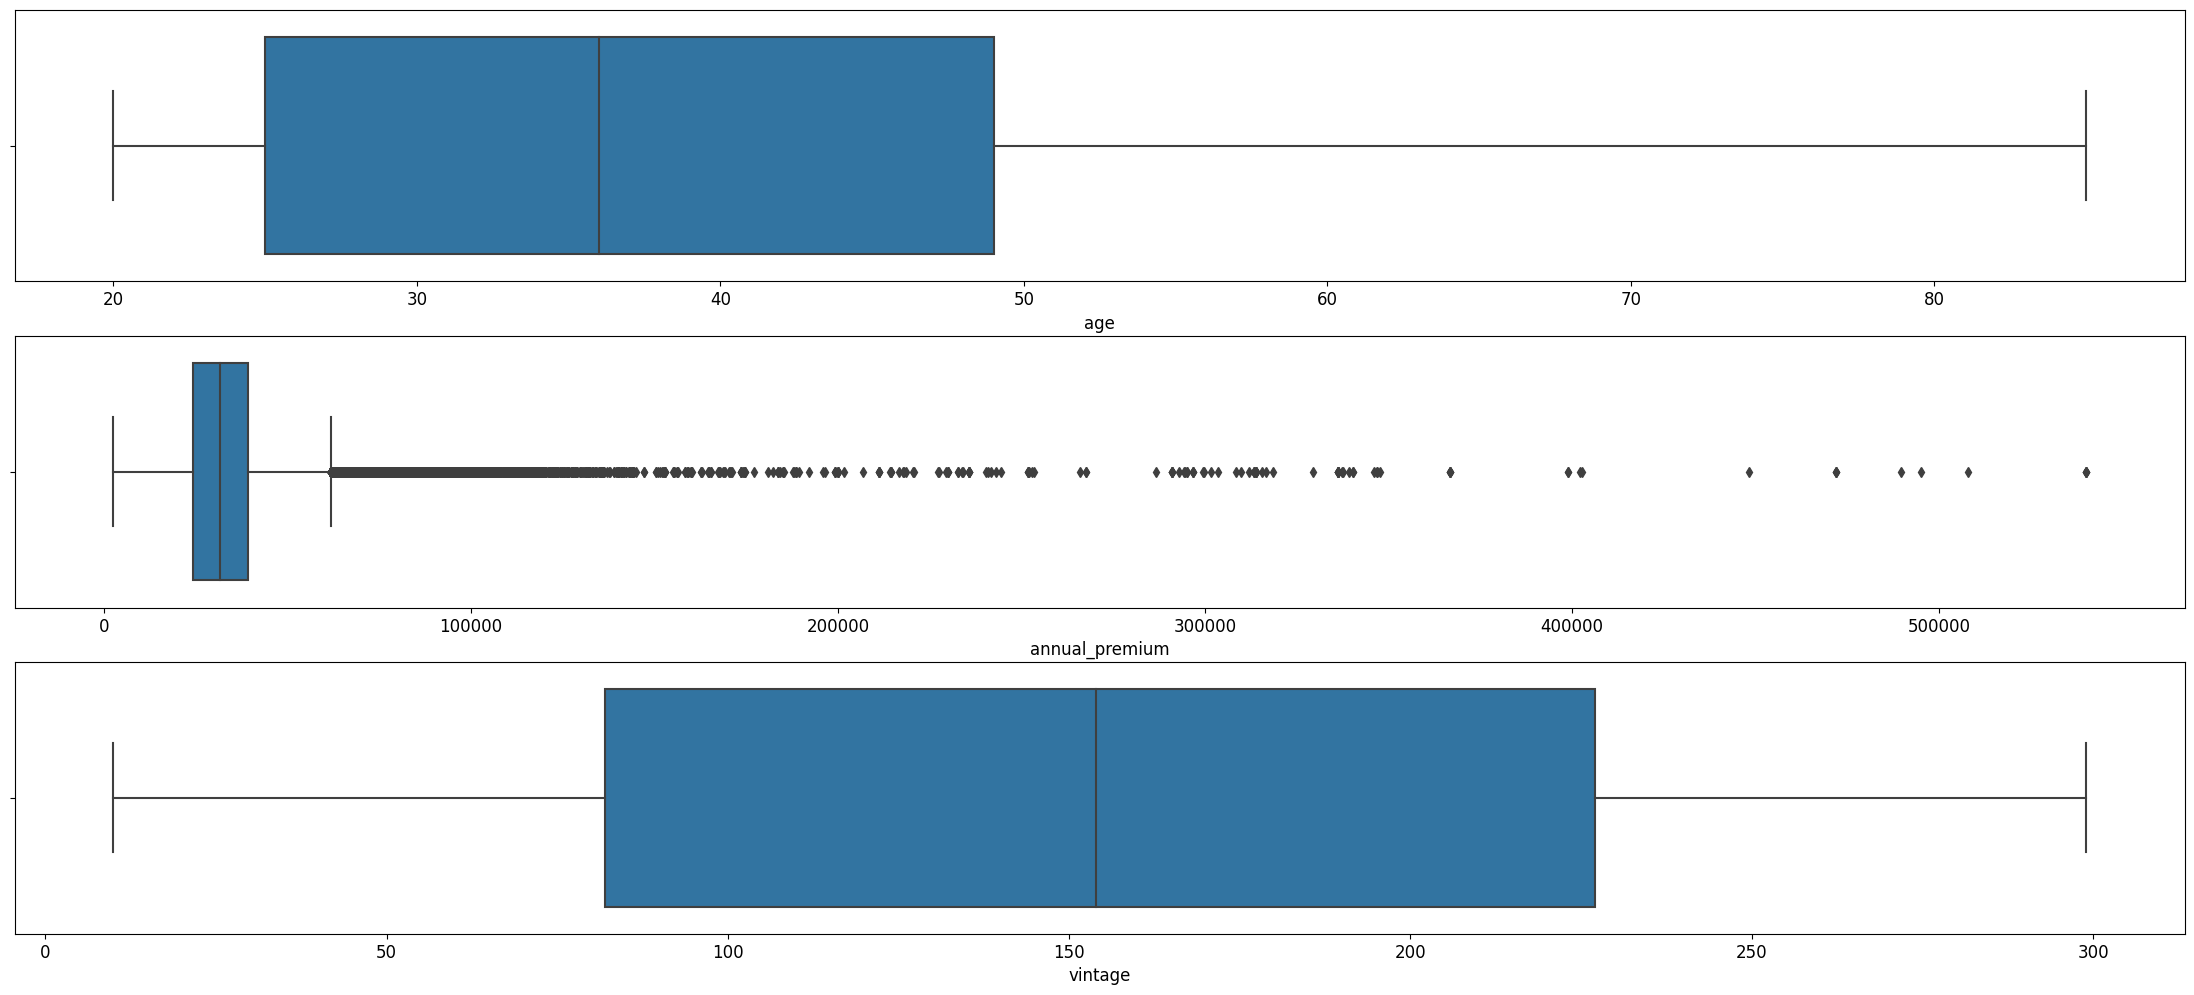

In [18]:
# define figure
_, ax = plt.subplots(nrows=3, ncols=1, figsize=(28,12))
(ax1, ax2, ax3) = ax

# plot
sns.boxplot(x='age', data=df_raw, ax=ax1);
sns.boxplot(x='annual_premium', data=df_raw, ax=ax2);
sns.boxplot(x='vintage', data=df_raw, ax=ax3);

In [19]:
# rows before deleting outliers
print('Before: {:,}'.format(len(df_raw)))

# calculate quantiles
q75, q25 = np.percentile(df_raw['annual_premium'], 75), np.percentile(df_raw['annual_premium'], 25)

# calculate interquantile range
iqr = q75 - q25

# calculate outliers cut off
cut_off = 1.5 * iqr
lower, upper = q25 - cut_off, q75 + cut_off

# remove outliers
df_raw = df_raw.loc[[False if x <= lower or x >= upper else True for x in df_raw['annual_premium']]]

# rows after deleting outliers
print('After: {:,}'.format(len(df_raw)))

Before: 381,109
After: 370,789


## 1.7. Imbalance
* High data imbalance

In [20]:
df_raw['response'].value_counts(normalize=True)

0    0.878219
1    0.121781
Name: response, dtype: float64

## 1.8. Descriptive statistics

In [21]:
num_attributes = df_raw[['age', 'annual_premium', 'vintage']]
cat_attributes = df_raw.select_dtypes(include=['object', 'category'])

### 1.8.1. Numerical features

In [22]:
# calculate central tendency and disperion metrics
num_attributes_desc = pd.DataFrame({
                          'Mean': num_attributes.apply(np.mean),
                          'Median': num_attributes.apply(np.median),
                          'Std. deviation': num_attributes.apply(np.std),
                          'Min': num_attributes.apply(np.min),
                          'Max': num_attributes.apply(np.max),
                          'Range': num_attributes.apply(lambda x: np.max(x) - np.min(x)),
                          'Skew': num_attributes.apply(lambda x: x.skew()),
                          'Kurtosis': num_attributes.apply(lambda x: x.kurtosis())
                      })

# check it out
num_attributes_desc

,Mean,Median,Std. deviation,Min,Max,Range,Skew,Kurtosis
age,38.670344,36.0,15.440145,20.0,85.0,65.0,0.683788,-0.542516
annual_premium,29264.643973,31319.0,14743.036776,2630.0,61892.0,59262.0,-0.519684,-0.333414
vintage,154.345442,154.0,83.670366,10.0,299.0,289.0,0.002652,-1.200591


### 1.8.2. Categorical features

In [23]:
cat_attributes.describe().T

,count,unique,top,freq
gender,370789,2,Male,200319
vehicle_age,370789,3,1-2 Year,194212
vehicle_damage,370789,2,Yes,186561


# **2. Feature engineering**

## 2.1. Phenomenon modeling

In [24]:
# age
df_raw.loc[:, 'older_than_36'] = df_raw.loc[:, 'age'].apply(lambda x: 1 if x > 36 else 0)

# vintage
df_raw.loc[:, 'vintage_weeks'] = df_raw.loc[:, 'vintage'].apply(lambda x: x/7)
df_raw.loc[:, 'vintage_months'] = df_raw.loc[:, 'vintage'].apply(lambda x: x/30)

# annual_premium
df_raw.loc[:, 'annual_premium_per_age'] = df_raw.loc[:, 'annual_premium'] / df_raw.loc[:, 'age']
df_raw.loc[:, 'annual_premium_per_vintage'] = df_raw.loc[:, 'annual_premium'] / df_raw.loc[:, 'vintage']
df_raw.loc[:, 'annual_premium_per_vintage_weeks'] = df_raw.loc[:, 'annual_premium'] / df_raw.loc[:, 'vintage_weeks']
df_raw.loc[:, 'annual_premium_per_vintage_months'] = df_raw.loc[:, 'annual_premium'] / df_raw.loc[:, 'vintage_months']

# customer characteristic
df_raw.loc[:, 'customer_characteristic'] = df_raw.loc[:, 'gender'].map({'Male': 0, 'Female': 1}).astype(int) \
                                           + df_raw.loc[:, 'vehicle_age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).astype(int) \
                                           + df_raw.loc[:, 'vehicle_damage'].map({'No': 0, 'Yes': 1}).astype(int) \
                                           + df_raw.loc[:, 'previously_insured'].astype(int) \
                                           + df_raw.loc[:, 'age'].apply(lambda x: 2 if x >= 20 and x < 40
                                                                                    else 1 if x >= 40 and x < 60
                                                                                    else 0)

## 2.2. Filtering

In [25]:
# df_raw[(df_raw['driving_license'] == 0) & (df_raw['vehicle_age'] != '< 1 Year')]

## Checkpoint

In [26]:
# save cleaned dataset
df_raw.to_parquet('../data/interim/df_cleaned.parquet')

# remove raw data from memory
del df_raw

In [6]:
# load it
df = pd.read_parquet('../data/interim/df_cleaned.parquet')
df.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,older_than_36,vintage_weeks,vintage_months,annual_premium_per_age,annual_premium_per_vintage,annual_premium_per_vintage_weeks,annual_premium_per_vintage_months,customer_characteristic
0,1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1,1,31.000000,7.233333,919.409091,186.423963,1304.967742,5592.718894,4
1,2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0,1,26.142857,6.100000,441.263158,183.256831,1282.797814,5497.704918,1
2,3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1,1,3.857143,0.900000,814.765957,1418.296296,9928.074074,42548.888889,4
3,4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0,0,29.000000,6.766667,1362.809524,140.980296,986.862069,4229.408867,3
4,5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0,0,5.571429,1.300000,948.137931,705.025641,4935.179487,21150.769231,4


# **3. Exploratory data analysis**

## 3.1. Univariate analysis

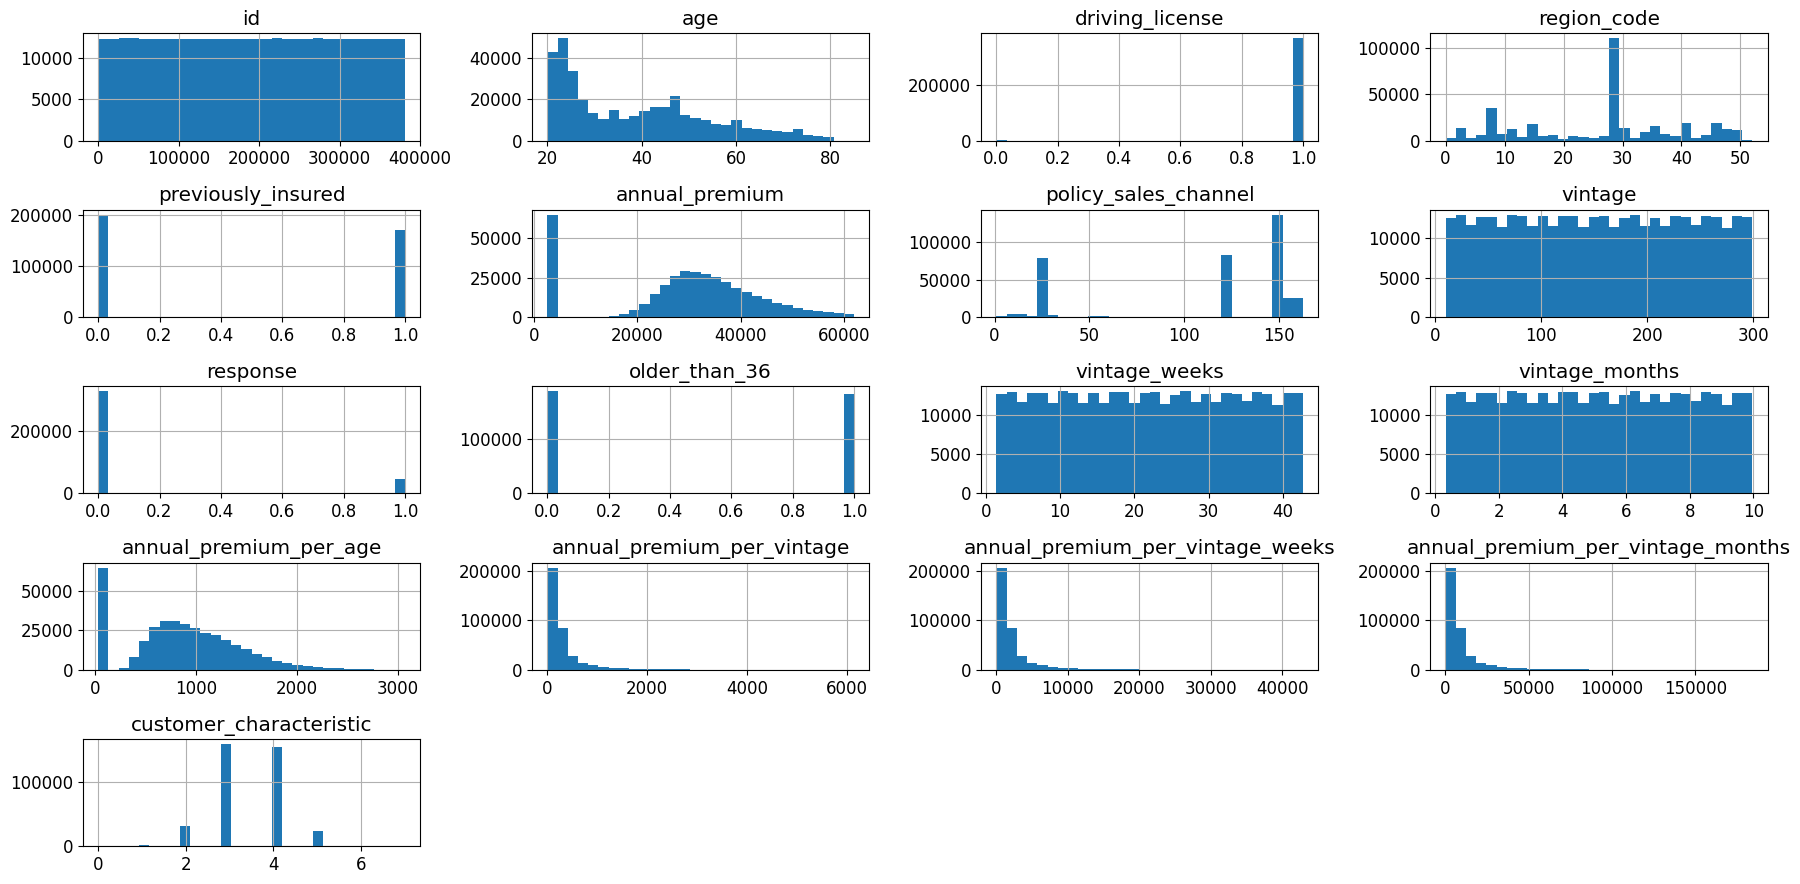

In [28]:
# plot
df.hist(bins=30);
plt.tight_layout()

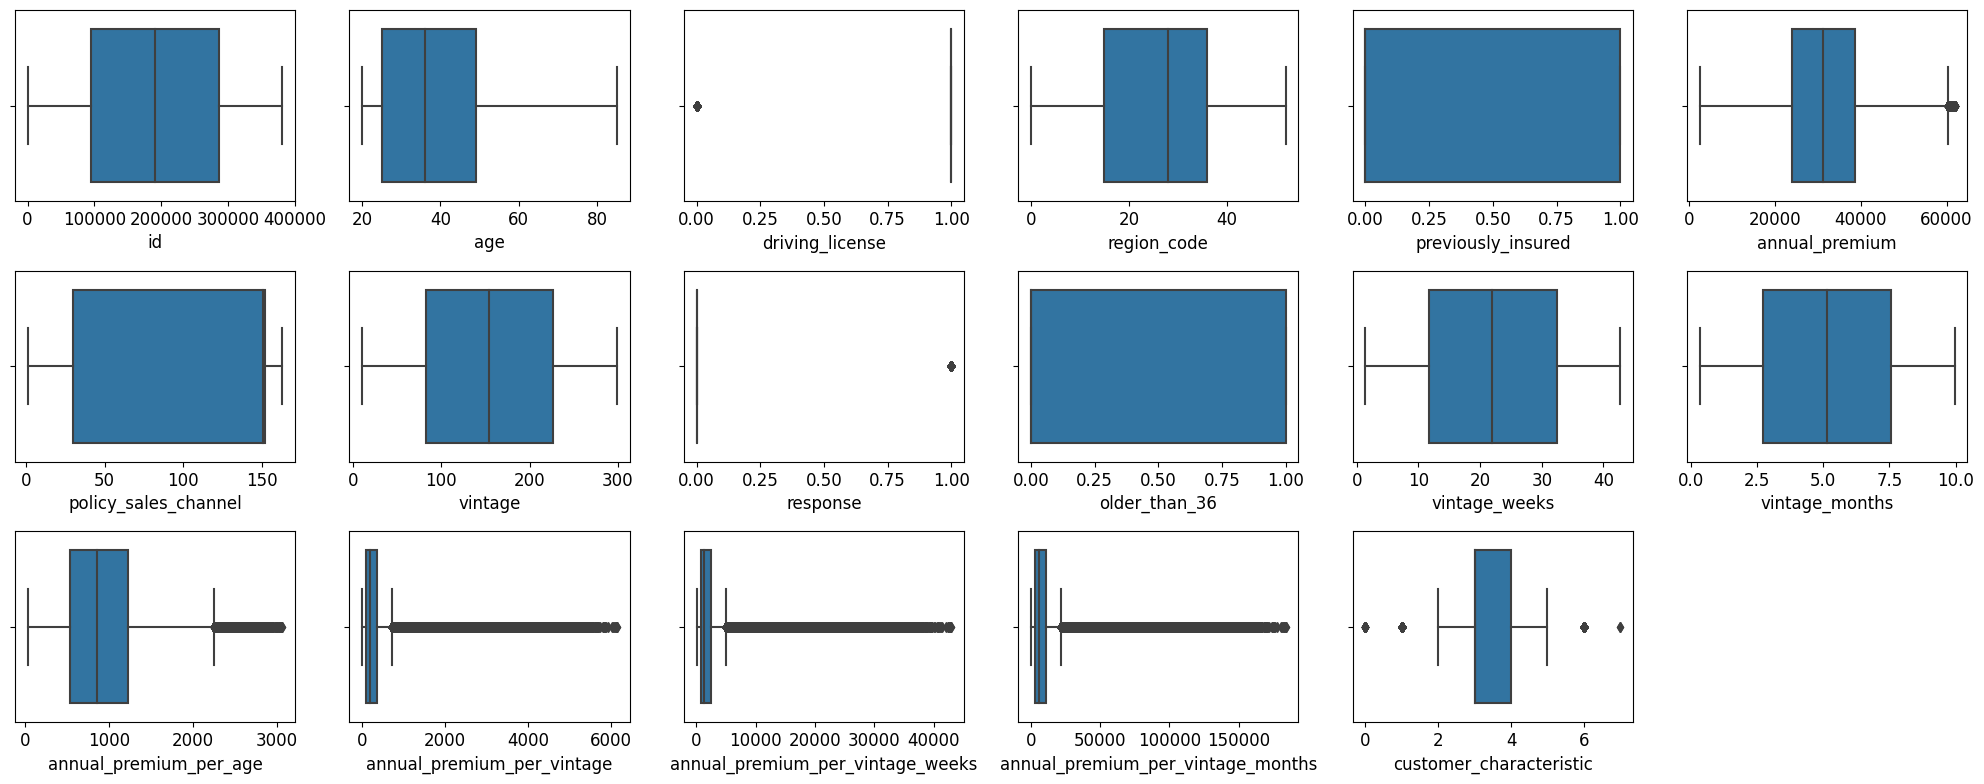

In [29]:
# plot settings
univariate_columns = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(20, 8))

# plot
for i in range(0, len(univariate_columns)):
    plt.subplot(3,6,i+1)
    sns.boxplot(x=df[univariate_columns[i]])
    plt.tight_layout()

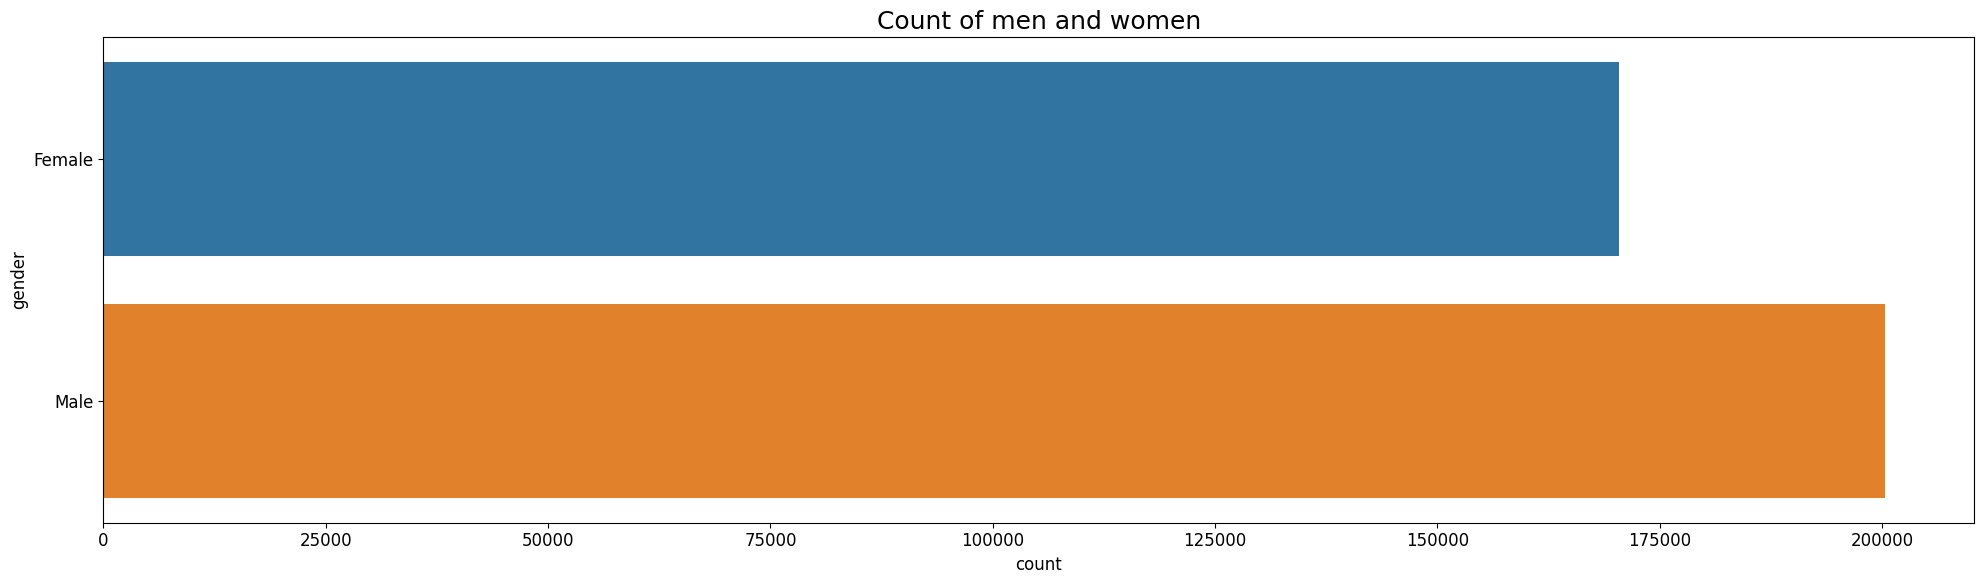

In [30]:
# plot
plt.figure(figsize=(20, 6))
sns.countplot(y=df['gender']);
plt.title('Count of men and women', fontsize=18);
plt.tight_layout()

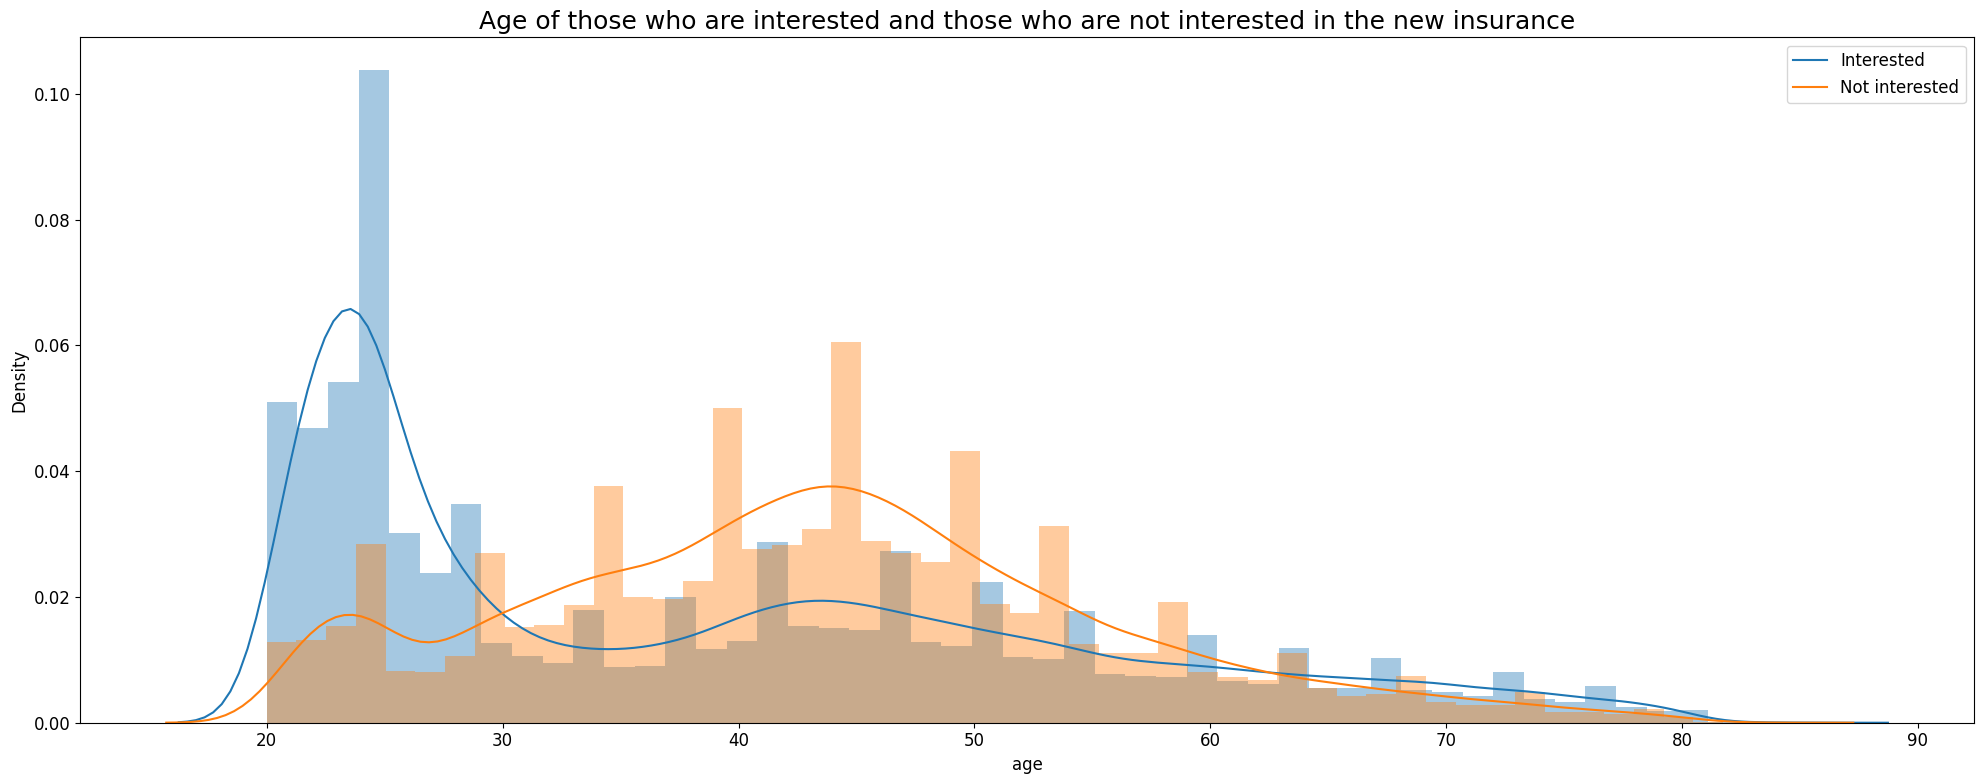

In [31]:
# plot settings
plt.figure(figsize=(20,8))

# plot
sns.distplot(df.loc[df['response'] == 0, 'age']);
sns.distplot(df.loc[df['response'] == 1, 'age']);
plt.title('Age of those who are interested and those who are not interested in the new insurance', fontsize=18);
plt.legend(['Interested', 'Not interested']);
plt.tight_layout()

## 3.2. Bivariate analysis

## Problem mind map

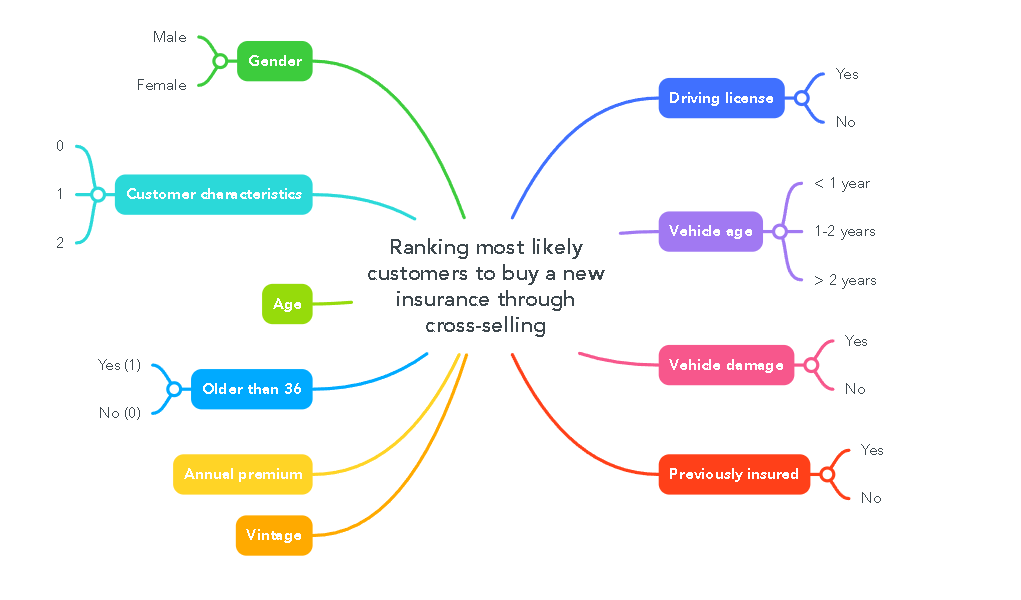

In [32]:
Image('../reports/imgs/mind-map.png')

## Hypotheses list

ID     | Hypothesis | Relevance | Conclusions
-------|------------|-----------|-------------
H01.   |Customers without driving licenses tend to want less vehicle insurance|<font color='blue'>Low</font>|<font color='green'>True</font>
H02.   |Women tend to want more vehicle insurance| <font color='yellow'>Medium</font>| <font color='red'>False</font>
H03.   |Customers aged between 36-45 tend to want more vehicle insurance|<font color='yellow'>Medium</font>|<font color='red'>False</font>
H04.   |Customers with a history of damage to their vehicle tend to want more vehicle insurance|<font color='red'>High</font>|<font color='green'>True</font>
H05.   |Customers with new vehicles (< 1 year) tend to want more vehicle insurance|<font color='red'>High</font> |<font color='red'>False</font>

### 3.2.1. Hypothesis 01 - Customers without driving licenses tend to want less vehicle insurance
<font color='green'>True</font>

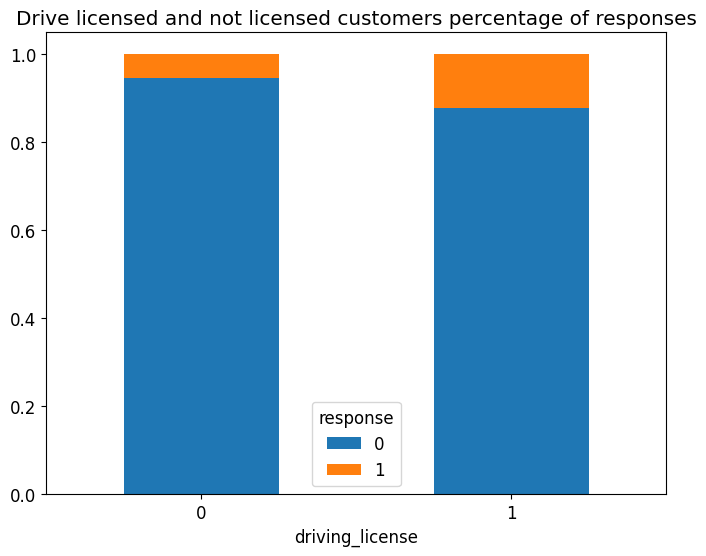

In [33]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
pd.crosstab(df['driving_license'], df['response']).apply(lambda x: x / x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax);
plt.title('Drive licensed and not licensed customers percentage of responses');
plt.xticks(rotation=0);

### 3.2.2. Hypothesis 02 - Women tend to want more vehicle insurance
<font color='red'>False</font>

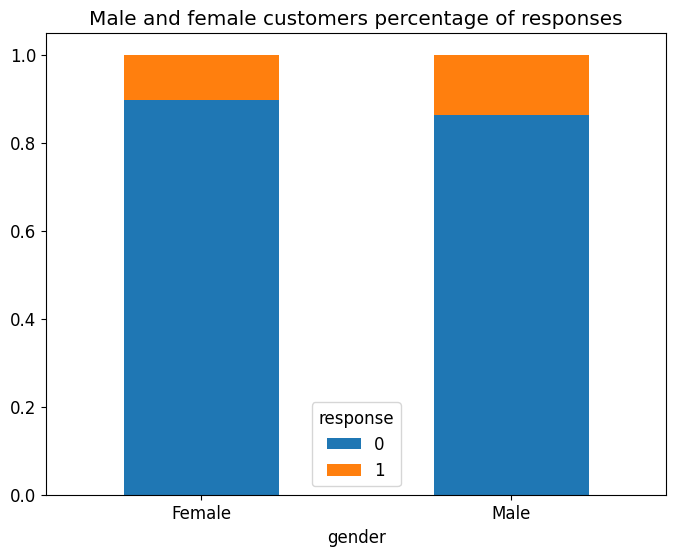

In [34]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
pd.crosstab(df['gender'], df['response']).apply(lambda x: x / x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax);
plt.title('Male and female customers percentage of responses');
plt.xticks(rotation=0);

### 3.2.3. Hypothesis 03 - Customers aged between 36-45 tend to want more vehicle insurance
<font color='red'>False</font>

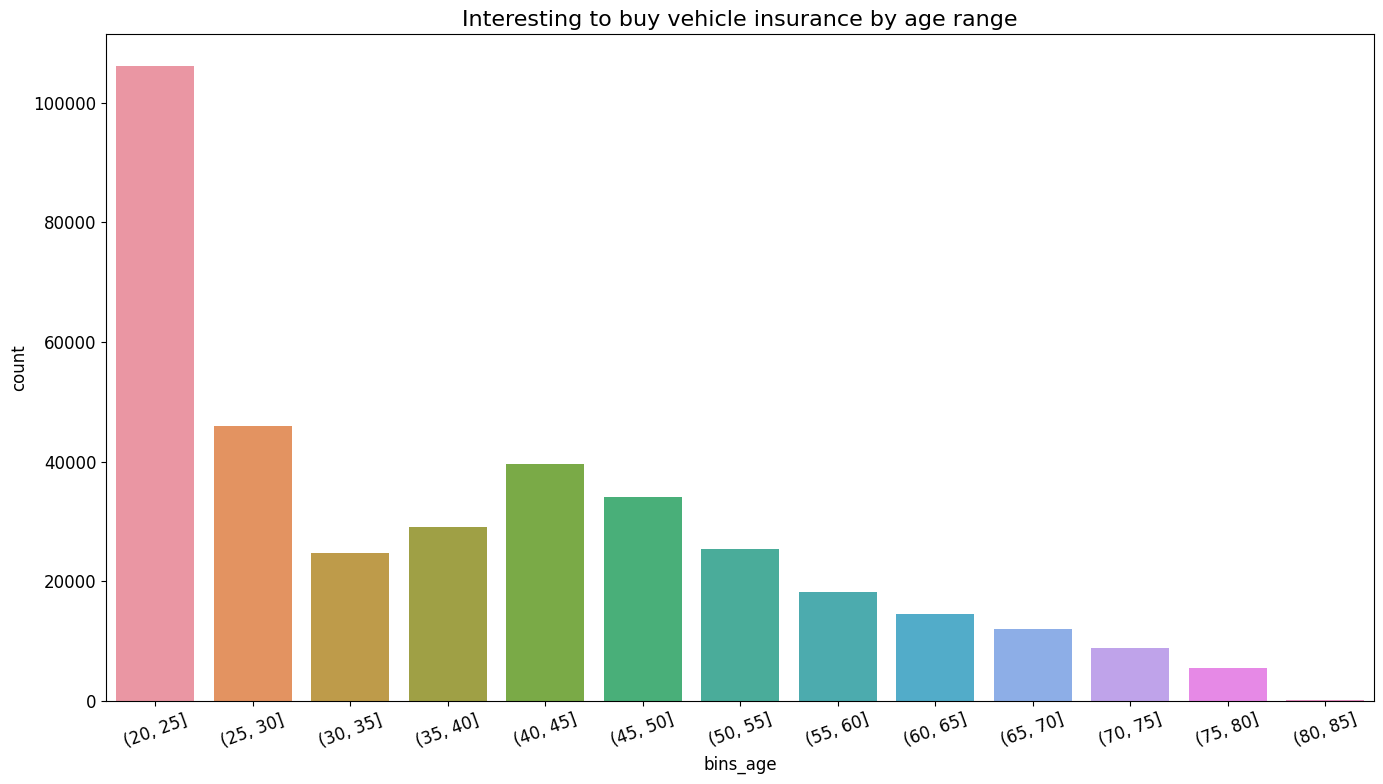

In [35]:
# define data
aux = df.copy()

# bins
n_bins = list(np.arange(df['age'].min(), df['age'].max()+1, 5))
aux['bins_age'] = pd.cut(aux['age'], bins=n_bins)

# plot
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,8))
sns.countplot(aux['bins_age'], ax=ax);
plt.title('Interesting to buy vehicle insurance by age range', fontsize=16);
plt.xticks(rotation=20);
plt.tight_layout()

### 3.2.4. Hypothesis 04 - Customers with a history of damage to their vehicle tend to want more vehicle insurance
<font color='green'>True</font>

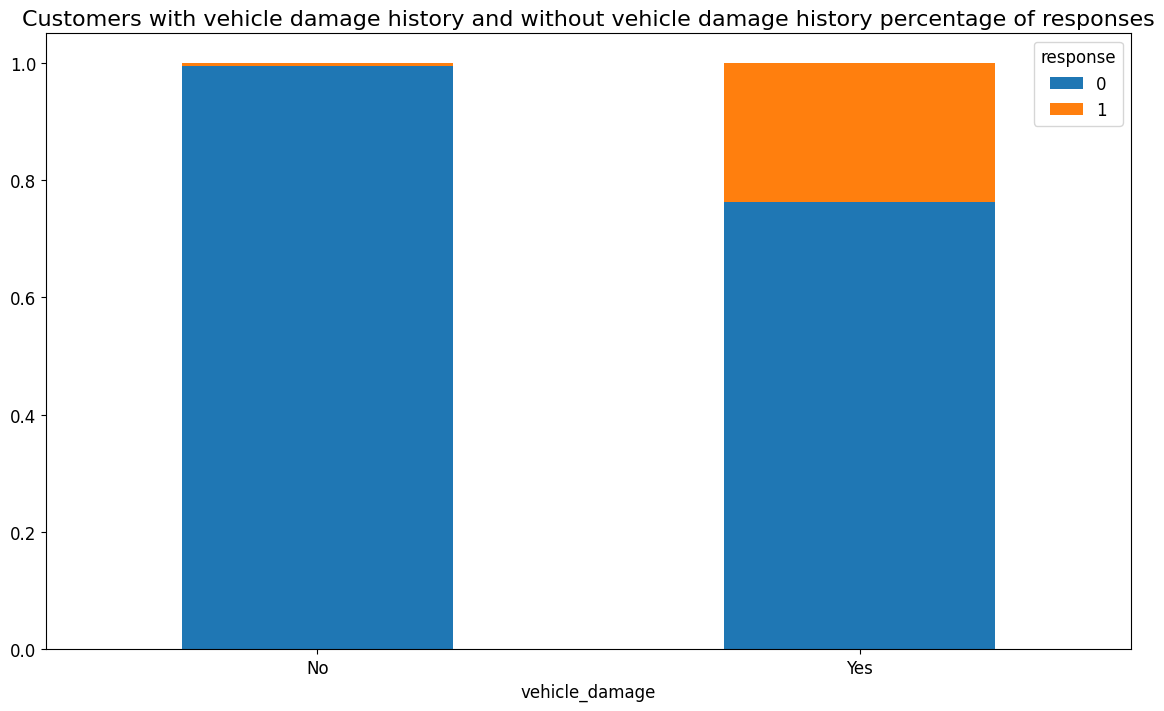

In [36]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,8))
pd.crosstab(df['vehicle_damage'], df['response']).apply(lambda x: x / x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax);
plt.title('Customers with vehicle damage history and without vehicle damage history percentage of responses', fontsize=16);
plt.xticks(rotation=0);

### 3.2.5. Hypothesis 05 - Customers with new vehicles (< 1 year) tend to want more vehicle insurance
<font color='red'>False</font>

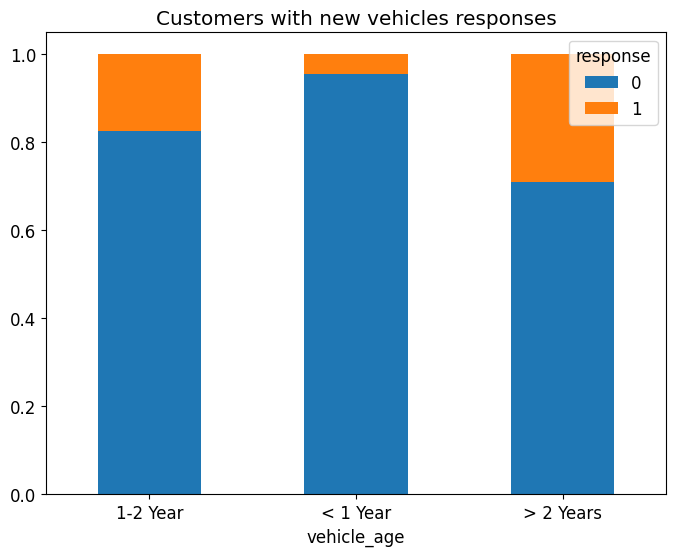

In [37]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
pd.crosstab(df['vehicle_age'], df['response']).apply(lambda x: x / x.sum(), axis=1).plot(kind='bar', stacked=True, ax=ax);
plt.title('Customers with new vehicles responses');
plt.xticks(rotation=0);

## 3.3. Multivariate analysis

### 3.3.1. Numerical variables

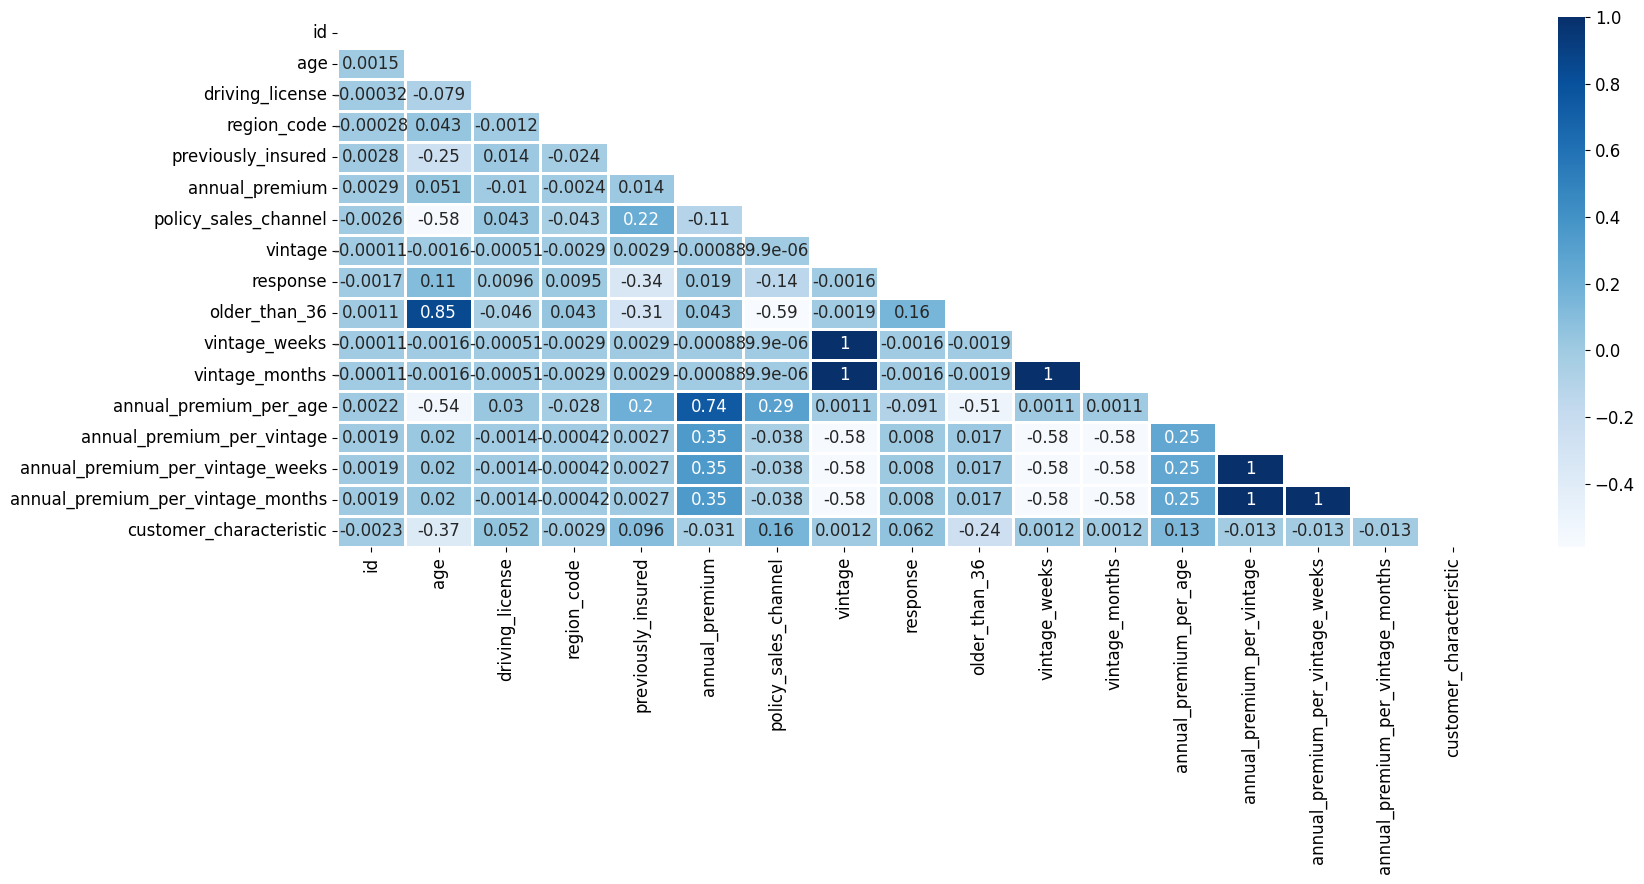

In [38]:
# compute the correlation matrix
num_corr = df.select_dtypes(include=['int64', 'float64']).corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(num_corr, dtype=bool))

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(num_corr, mask=mask, cmap='Blues', annot=True, linewidths=2);
plt.tight_layout()

### 3.3.2. Categorical variables

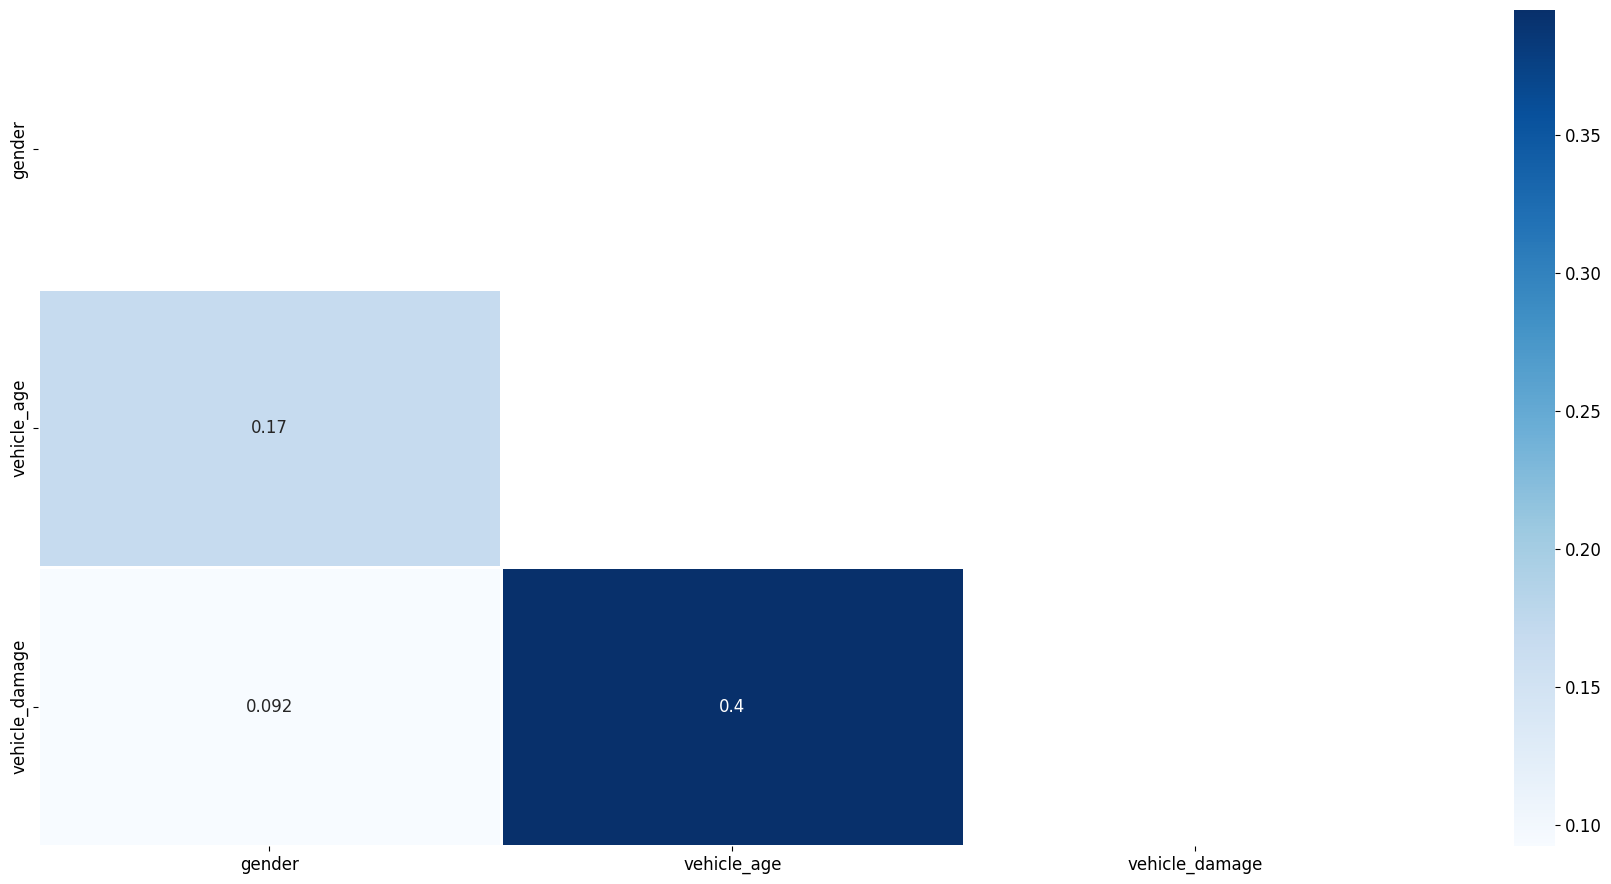

In [39]:
df_cat_corr_raw = df.select_dtypes(include=['object', 'category'])
cat_corr = {}

for col_x in df_cat_corr_raw.columns:
    cat_corr[col_x] = []

    for col_y in df_cat_corr_raw.columns:
        # calculate cramer's v
        cat_corr[col_x].append(cramers_v(df_cat_corr_raw[col_x], df_cat_corr_raw[col_y]))
    
    # store results
    df_cat_corr = pd.DataFrame(cat_corr).set_index(df_cat_corr_raw.columns)

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_cat_corr, dtype=bool))

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_cat_corr, mask=mask, cmap='Blues', annot=True, linewidths=2);
plt.tight_layout()

# **4. Data balancing**

## 4.1. Encoding

### 4.1.1. Frequency encoding

In [7]:
# encode
col_frequency = df.groupby('policy_sales_channel').size() / len(df)
df.loc[:, 'policy_sales_channel'] = df.loc[:, 'policy_sales_channel'].map(col_frequency)

col_frequency = df.groupby('region_code').size() / len(df)
df.loc[:, 'region_code'] = df.loc[:, 'region_code'].map(col_frequency)

### 4.1.2. One-hot encoding

In [8]:
# encode
df = pd.get_dummies(df, columns=['gender', 'vehicle_age', 'vehicle_damage'], drop_first=True)

## 4.2. Sampling

In [9]:
# over sampling
X_over, y_over = RandomOverSampler(sampling_strategy=0.5).fit_resample(df.drop(['id', 'response'], axis=1), df['response'])

# under sampling
X_combined, y_combined = RandomUnderSampler(sampling_strategy=0.8).fit_resample(X_over, y_over)

# check imbalance
print(y_combined.value_counts(normalize=True))

0    0.555555
1    0.444445
Name: response, dtype: float64


In [10]:
# check data information
X_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366338 entries, 0 to 366337
Data columns (total 19 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   age                                366338 non-null  int64  
 1   driving_license                    366338 non-null  int64  
 2   region_code                        366338 non-null  float64
 3   previously_insured                 366338 non-null  int64  
 4   annual_premium                     366338 non-null  float64
 5   policy_sales_channel               366338 non-null  float64
 6   vintage                            366338 non-null  int64  
 7   older_than_36                      366338 non-null  int64  
 8   vintage_weeks                      366338 non-null  float64
 9   vintage_months                     366338 non-null  float64
 10  annual_premium_per_age             366338 non-null  float64
 11  annual_premium_per_vintage         3663

# **5. Data preprocessing**

## 5.1. Data split

In [11]:
# split data into training and validation
X_train, X_val, y_train, y_val = ms.train_test_split(X_combined, y_combined, test_size=0.2)

# test data sizes
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0] == y_val.shape[0]

## 5.2. Standardization

In [12]:
# instantiate the scaler
ss = pp.StandardScaler()

# define columns to standardize
cols_to_standardize = ['annual_premium', 'annual_premium_per_age']

# rescale
for col in cols_to_standardize:
    X_train.loc[:, [col]] = ss.fit_transform(X_train.loc[:, [col]])
    joblib.dump(ss, f'../src/pipeline/parameters/ss_{col}.joblib')
    X_val.loc[:, [col]] = ss.transform(X_val.loc[:, [col]])

## 5.3. Rescaling

### 5.3.1 MinMax scaler

In [13]:
# instantiate the scaler
mms = pp.MinMaxScaler()

# define columns to rescale
cols_to_rescale_mms = ['age', 'vintage', 'vintage_weeks', 'vintage_months', 'customer_characteristic',
                       'annual_premium', 'annual_premium_per_age']

# rescale
for col in cols_to_rescale_mms:
    X_train.loc[:, [col]] = mms.fit_transform(X_train.loc[:, [col]])
    joblib.dump(mms, f'../src/pipeline/parameters/mms_{col}.joblib')
    X_val.loc[:, [col]] = mms.transform(X_val.loc[:, [col]])

### 5.3.2. Robust scaler

In [14]:
# instantiate the scaler
rs = pp.RobustScaler()

# define columns to rescale
cols_to_rescale_rs = ['annual_premium_per_vintage',
                      'annual_premium_per_vintage_weeks',
                      'annual_premium_per_vintage_months']

# rescale
for col in cols_to_rescale_rs:
    X_train.loc[:, [col]] = rs.fit_transform(X_train.loc[:, [col]])
    joblib.dump(rs, f'../src/pipeline/parameters/rs_{col}.joblib')
    X_val.loc[:, [col]] = rs.transform(X_val.loc[:, [col]])

# **6. Feature selection**

In [16]:
# instantiate extra trees
xtrees_selector = ExtraTreesClassifier()

## 6.1. Boruta

In [ ]:
# instantiate the selector
boruta_selector = BorutaPy(estimator=xtrees_selector, n_estimators=100, verbose=1).fit(X_train.values, y_train.values)

In [47]:
# selected columns by boruta
boruta_features = [col for col, is_selected in zip(X_train.columns, boruta_selector.support_.tolist()) if is_selected]
boruta_features

['age',
 'region_code',
 'policy_sales_channel',
 'previously_insured',
 'annual_premium_per_age',
 'vehicle_age_< 1 Year',
 'vehicle_damage_Yes']

## 6.2. Feature importance

In [48]:
# fit the model
xtrees_selector.fit(X_train.values, y_train.values)

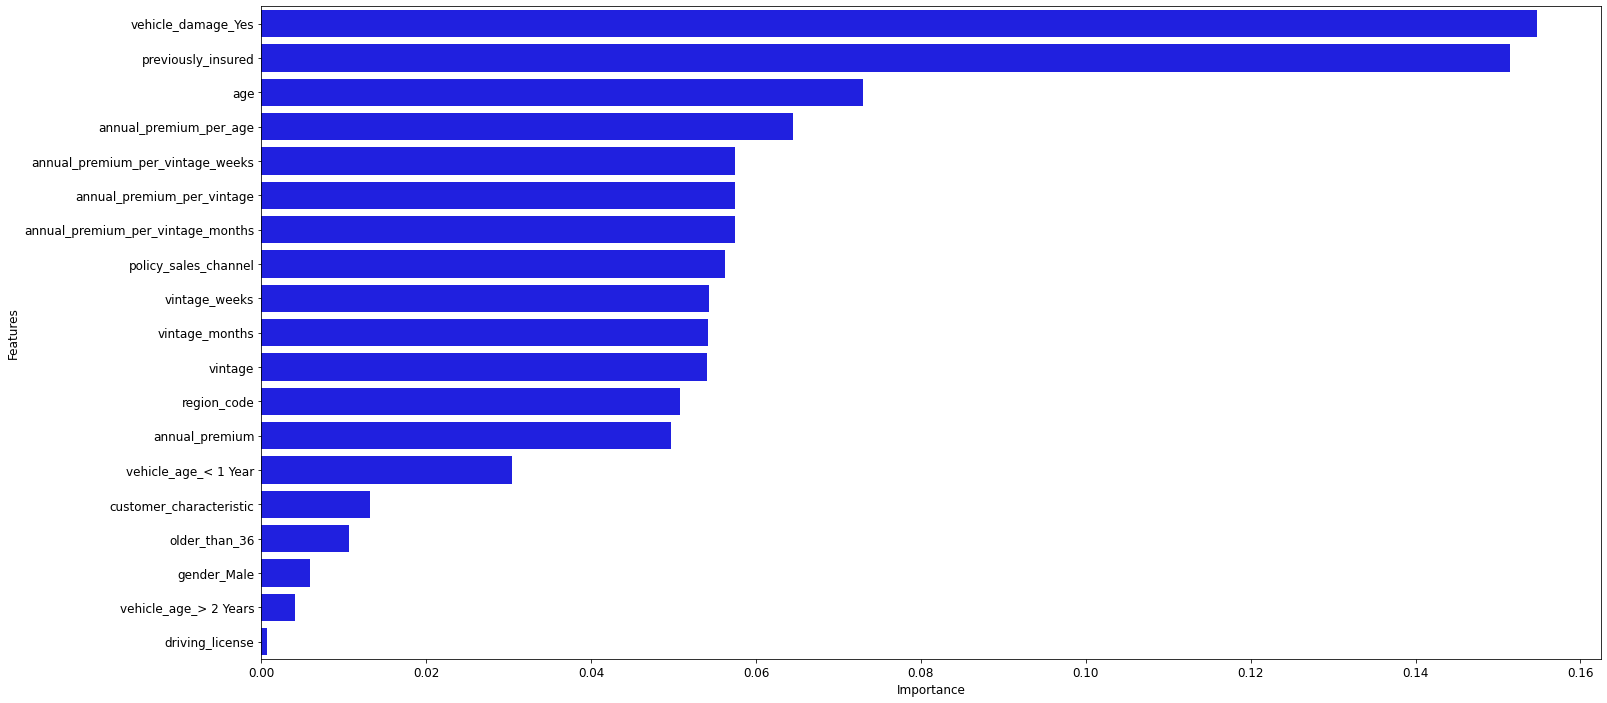

In [49]:
# store features importance
df_xtrees_selector = pd.DataFrame({'Features': X_train.columns,
                                   'Importance': xtrees_selector.feature_importances_})\
                                   .sort_values(by='Importance', ascending=False)\
                                   .reset_index(drop=True)

# plot
plt.figure(figsize=(28,12))
sns.barplot(x='Importance', y='Features', data=df_xtrees_selector, orient='h', color='blue');

## 6.3. Columns selection

In [15]:
cols_selected = ['age', 'region_code', 'policy_sales_channel', 'previously_insured',
                 'vehicle_damage_Yes', 'annual_premium', 'annual_premium_per_age']

# select columns
X_train = X_train.loc[:, cols_selected]
X_val = X_val.loc[:, cols_selected]

# check it out
X_train.sample(5)

,age,region_code,policy_sales_channel,previously_insured,vehicle_damage_Yes,annual_premium,annual_premium_per_age
73693,0.076923,0.086489,0.356451,1,0,0.864838,0.699484
269214,0.430769,0.268997,0.000065,0,1,0.000000,0.007853
88396,0.723077,0.023463,0.193916,0,1,0.565286,0.167373
309804,0.492308,0.011481,0.193916,0,1,0.000000,0.006465
64359,0.692308,0.268997,0.205980,0,1,0.807600,0.245580


# **7. Machine learning modeling**

In [16]:
# set K value
K = np.floor((1/2) * (y_val.shape[0]))

## 7.1. KNN

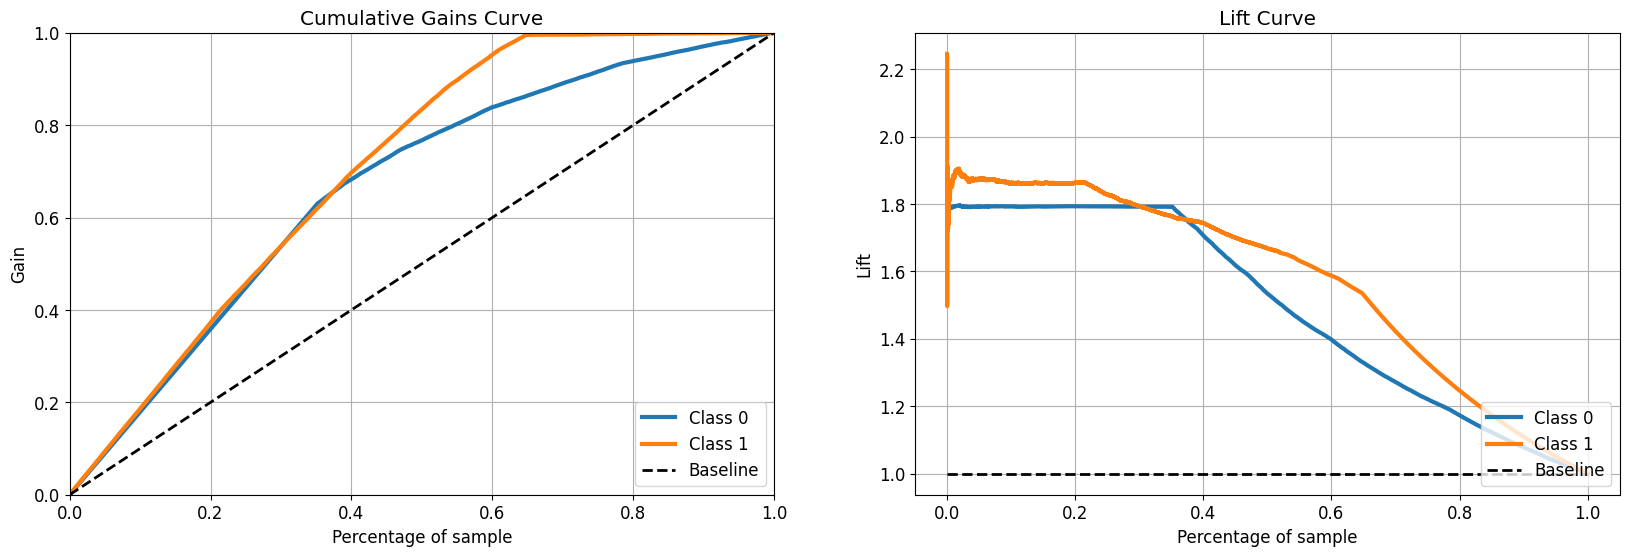

In [50]:
p_hat_knn = train_model(KNeighborsClassifier(), X_train, y_train, X_val, y_val)

In [51]:
# prepare data set
aux = X_val.copy()
aux['response'] = y_val.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat_knn, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat_knn, K)}')

Precision@K: 0.7437
Recall@K: 0.8351


## 7.2. Logistic regression

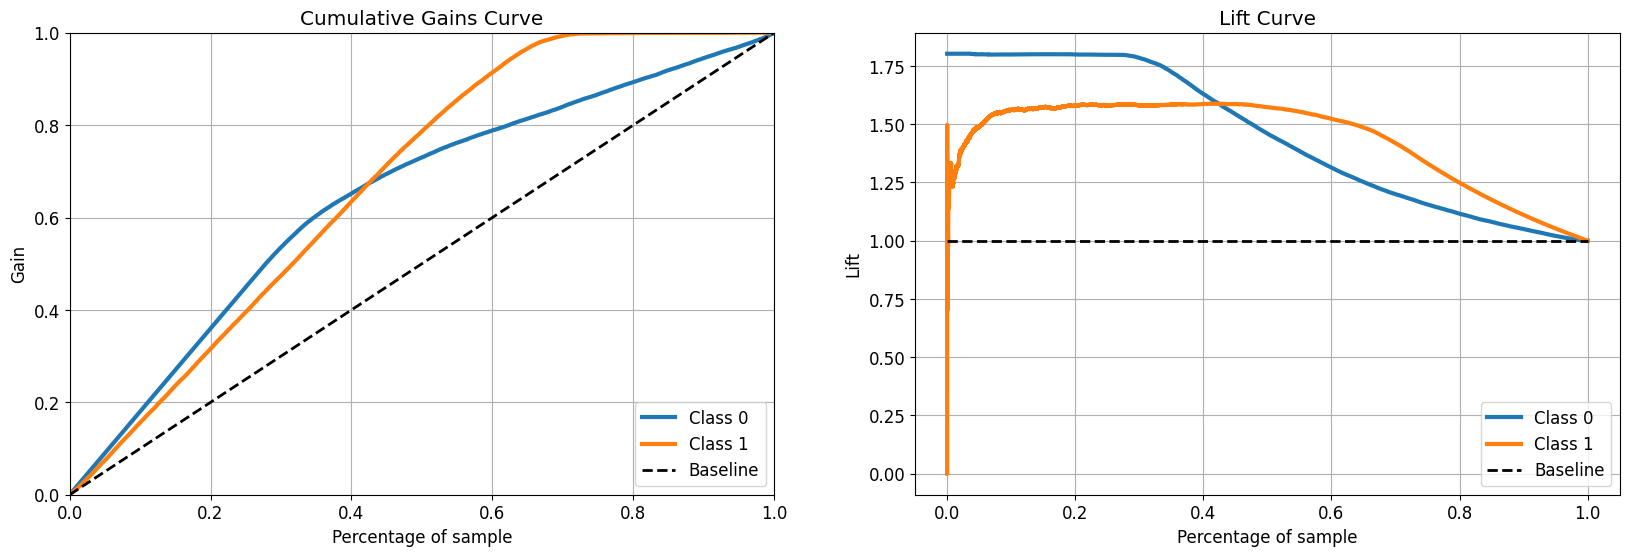

In [20]:
p_hat_lr = train_model(LogisticRegression(), X_train, y_train, X_val, y_val)

In [21]:
# prepare data set
aux = X_val.copy()
aux['response'] = y_val.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat_lr, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat_lr, K)}')

Precision@K: 0.7006
Recall@K: 0.7867


## 7.4. Random forest

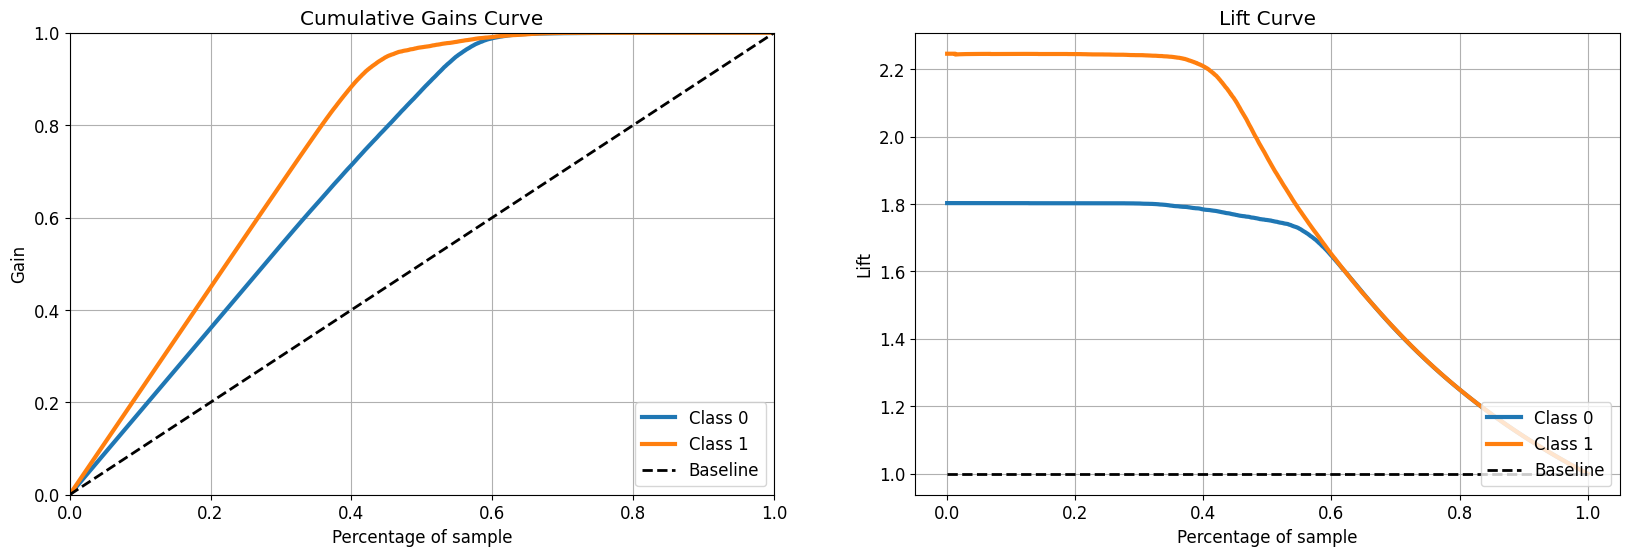

In [25]:
p_hat_rf = train_model(RandomForestClassifier(), X_train, y_train, X_val, y_val)

In [26]:
# prepare data set
aux = X_val.copy()
aux['response'] = y_val.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat_rf, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat_rf, K)}')

Precision@K: 0.8624
Recall@K: 0.9684


## 7.4. XGBoost

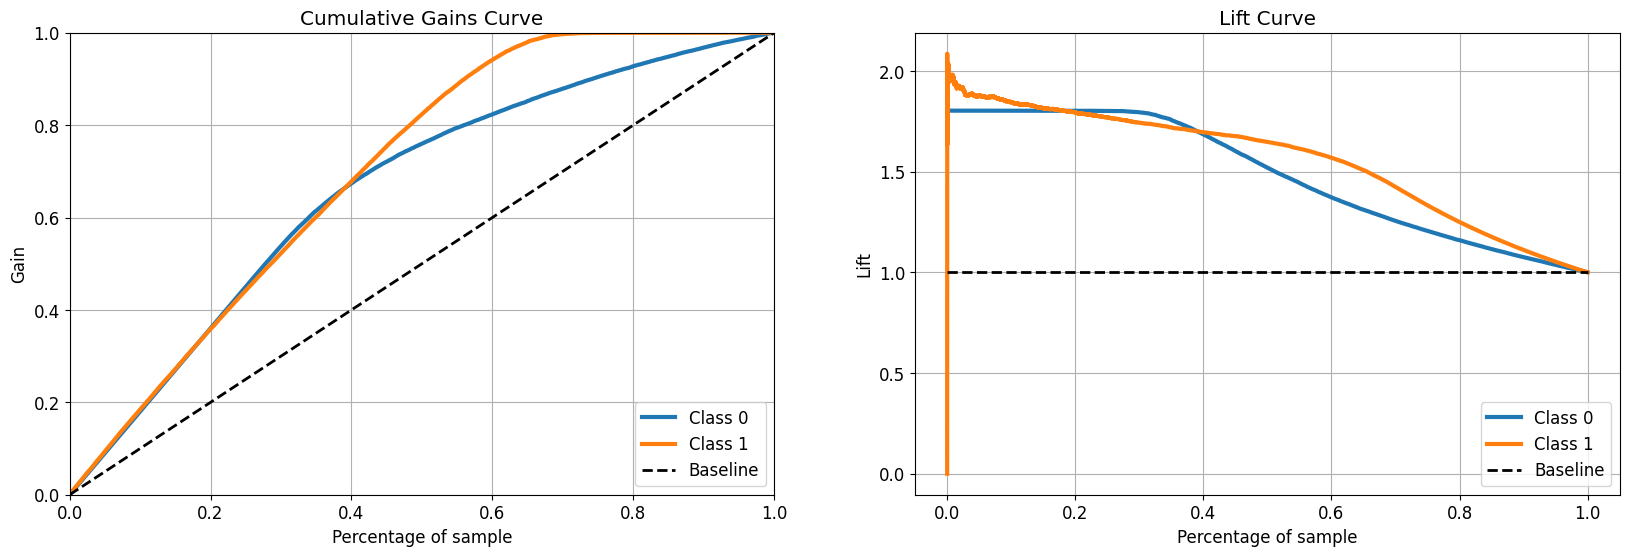

In [50]:
p_hat_xgb = train_model(XGBClassifier(), X_train, y_train, X_val, y_val)

In [51]:
# prepare data set
aux = X_val.copy()
aux['response'] = y_val.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat_xgb, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat_xgb, K)}')

Precision@K: 0.7336
Recall@K: 0.8238


## 7.5. Select model

In [52]:
list_estimators = [LogisticRegression(),
                   KNeighborsClassifier(),
                   RandomForestClassifier(),
                   XGBClassifier()]

# cross-validate
df_cross_validation = cross_validation(estimators=list_estimators, X=X_train, y=y_train, n_splits=5, shuffle=True, verbose=True)
df_cross_validation.sort_values(by='Precision@K', ascending=False)

fold=1, precision_at_29307.0=0.7053, recall_at_29307.0=0.7938
fold=2, precision_at_29307.0=0.703, recall_at_29307.0=0.7913
fold=3, precision_at_29307.0=0.7045, recall_at_29307.0=0.793
fold=4, precision_at_29307.0=0.7037, recall_at_29307.0=0.792
fold=5, precision_at_29307.0=0.698, recall_at_29307.0=0.7856
fold=6, precision_at_29307.0=0.7338, recall_at_29307.0=0.8259
fold=7, precision_at_29307.0=0.7353, recall_at_29307.0=0.8277
fold=8, precision_at_29307.0=0.7355, recall_at_29307.0=0.8279
fold=9, precision_at_29307.0=0.7347, recall_at_29307.0=0.827
fold=10, precision_at_29307.0=0.7335, recall_at_29307.0=0.8255
fold=11, precision_at_29307.0=0.8224, recall_at_29307.0=0.9257
fold=12, precision_at_29307.0=0.8245, recall_at_29307.0=0.928
fold=13, precision_at_29307.0=0.8198, recall_at_29307.0=0.9228
fold=14, precision_at_29307.0=0.8205, recall_at_29307.0=0.9235
fold=15, precision_at_29307.0=0.8211, recall_at_29307.0=0.9242
fold=16, precision_at_29307.0=0.7356, recall_at_29307.0=0.8279
fold=17

,Model,Precision@K,Recall@K
0,RandomForestClassifier,0.753 +/- 0.0502,0.8476 +/- 0.0566
0,XGBClassifier,0.7483 +/- 0.0443,0.8423 +/- 0.0498
0,KNeighborsClassifier,0.7187 +/- 0.0159,0.809 +/- 0.018
0,LogisticRegression,0.7029 +/- 0.0026,0.7911 +/- 0.0029


# **8. Hyperparameters fine tuning**

mlflow server --default-artifact-root ./mlflow --backend-store-uri sqlite:///mlflow/backend.db

In [19]:
MLFLOW_TRACKING_URI = 'http://127.0.0.1:5000'
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment(experiment_name='hyperparameters-optimization')

<Experiment: artifact_location='./mlflow/1', experiment_id='1', lifecycle_stage='active', name='hyperparameters-optimization', tags={}>

## 8.1. Bayesian search

In [37]:
def objective(params: Dict[str, Any]) -> None:
    ''' function to minimize '''
    with mlflow.start_run() as run:
        # instantiate the classifier
        clf = RandomForestClassifier(**params)

        # cross-validate
        df_results = cross_validation(estimators=[clf],
                                      X=X_train,
                                      y=y_train,
                                      n_splits=5,
                                      shuffle=True,
                                      verbose=False)

        # evaluate
        patk = float(df_results['Precision@K'][0].split()[0])
        ratk = float(df_results['Recall@K'][0].split()[0])

        # mlflow logging
        mlflow.set_tag('developer', 'Gabriel')
        mlflow.set_tag('model', 'Random Forest Classifier')

        mlflow.log_params(params)
        
        mlflow.log_metric(f'Precision at {K}', patk)
        mlflow.log_metric(f'Recall at {K}', ratk)
        
        mlflow.sklearn.log_model(clf.fit(X_train, y_train), 'sklearn-models')

        # since hyperopt will try to minimize this metric we need to do this operation
        loss = 1 - patk

        return {'status': STATUS_OK, 'loss': loss}

In [ ]:
# define hyperparameters to try out
search_space = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 200]),
    'max_depth': scope.int(hp.quniform('max_depth', 10, 100, 1)),
    'min_samples_split': hp.choice('min_samples_split', [2, 4, 10]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4]),
}

# initialize the optimizer and search
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

# check it out
print(best_result)

## 8.2. Persist and evaluate final model

In [17]:
best_params = {
    'n_estimators': 100,
    'max_depth': 40,
    'min_samples_split': 2,
    'min_samples_leaf': 2
}

# instantiate, fit and serialize the tuned model
model = RandomForestClassifier(**best_params).fit(X_train, y_train)
joblib.dump(model, '../models/rf_classifier_tuned.joblib')

['../models/rf_classifier_tuned.joblib']

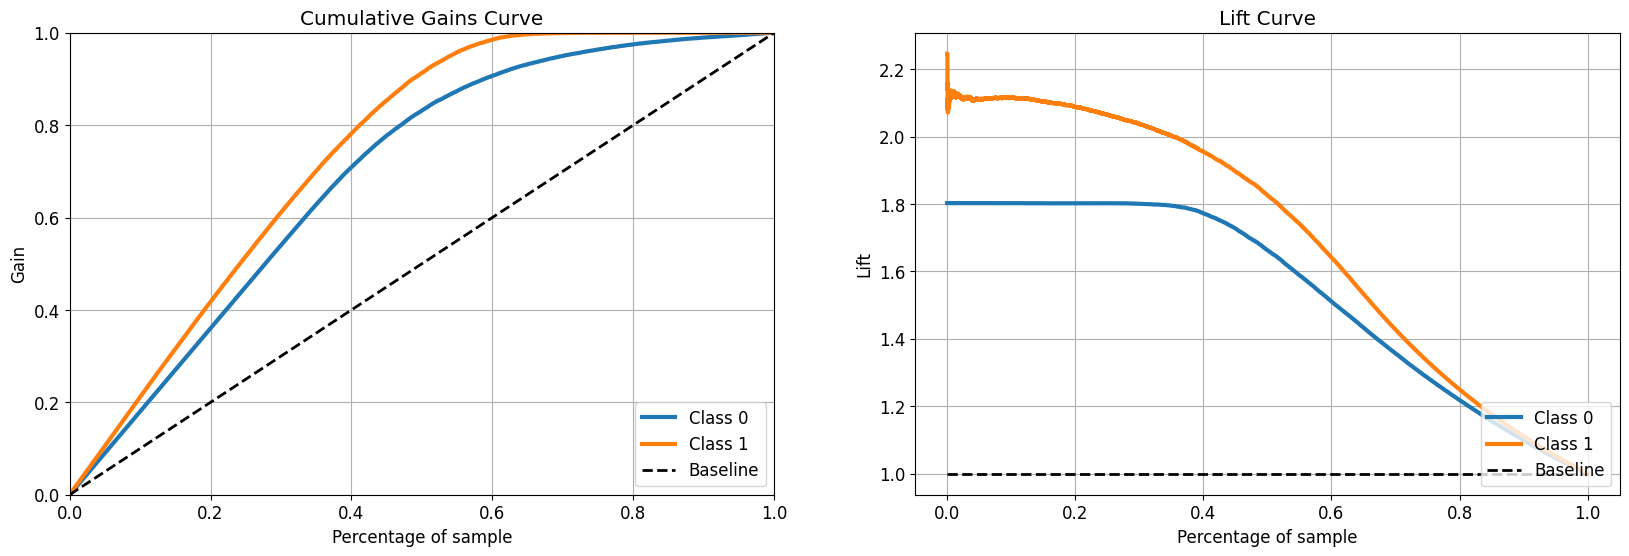

In [20]:
# predict
p_hat = model.predict_proba(X_val)

# plot settings
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
(ax1, ax2) = ax

# cumulative gain
plot_cumulative_gain(y_val, p_hat, ax=ax1);

# lift curve
plot_lift_curve(y_val, p_hat, ax=ax2);

In [21]:
# prepare data set
aux = X_val.copy()
aux['response'] = y_val.astype('int64').copy()

# calculate precision at k
print(f'Precision@K: {precision_at_k(aux, p_hat, K)}')

# calculate recall at k
print(f'Recall@K: {recall_at_k(aux, p_hat, K)}')

Precision@K: 0.8132
Recall@K: 0.9132


# **9. Calibration**

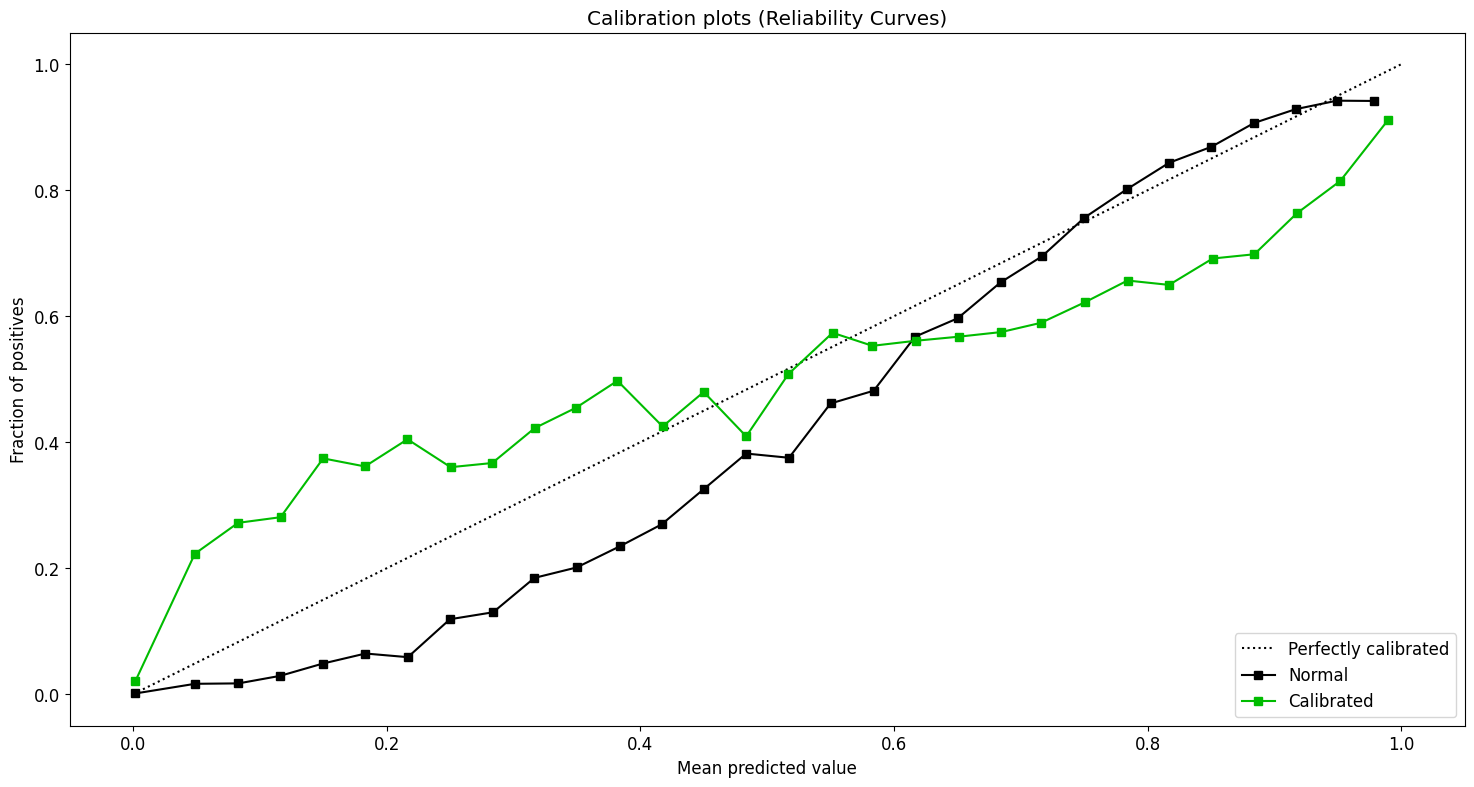

In [22]:
# calibrate
model_calibrated = CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv='prefit').fit(X_train, y_train)

# predict
p_hat_calibrated = model_calibrated.predict_proba(X_val)

# plot calibration curve
plot_calibration_curve(y_true=y_val,
                       clf_names=['Normal', 'Calibrated'],
                       probas_list=[p_hat, p_hat_calibrated],
                       n_bins=30);

## 9.1. Evaluate calibrated model

In [23]:
# calculate brier score loss for each model
bsl_model = brier_score_loss(y_val, p_hat[:, 1])
bsl_model_calibrated = brier_score_loss(y_val, p_hat_calibrated[:, 1])

# compare them
print(f'Brier score loss before the calibration: {bsl_model}')
print(f'Brier score loss after the calibration: {bsl_model_calibrated}\n')

# check it out
if bsl_model_calibrated > bsl_model:
    print('Calibrated model is NOT better.')
else:
    print('Calibrated model is better.')

Brier score loss before the calibration: 0.0971398047104825
Brier score loss after the calibration: 0.10245788276955997

Calibrated model is NOT better.


# **10. Deploy**

## 10.1. API test

In [29]:
df_test = pd.read_csv('../data/raw/test.csv').head()

In [82]:
import json
import requests

url = 'http://localhost:8000/predict'
data = json.dumps(df_test.to_dict(orient='records'))
header = {'Content-type': 'application/json'}

r = requests.post(url=url, data=data, headers=header)
print(r.status_code)

500


In [93]:
from fastapi.testclient import TestClient
from src.api.routes.predict import predict

client = TestClient(predict)

response = client.post('/', data)

FileNotFoundError: [Errno 2] No such file or directory: '/home/sheep/repos/vehicle-insurance-cross-sell/notebooks/models/rf_classifier_tuned.joblib'

In [83]:
df_test = pd.DataFrame(r.json(), columns=r.json()[0].keys())
df_test.head(5)

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,annual_premium_per_age,score
0,354526,Male,78,0.0007,0.2058,0,42960.0000,159,1,1-2 Year,Yes,550.7692,0.7867
1,81352,Female,76,0.0350,0.0017,0,32039.0000,140,1,1-2 Year,Yes,421.5658,0.7467
2,116974,Male,79,0.2790,0.0004,0,38325.0000,64,1,> 2 Years,Yes,485.1266,0.7417
3,300890,Female,76,0.0519,0.1954,0,33086.0000,162,1,1-2 Year,Yes,435.3421,0.7183
4,82394,Female,80,0.2790,0.0264,0,31396.0000,55,1,1-2 Year,Yes,392.4500,0.7067


In [106]:
df_test = pd.concat([X_test, y_test], axis=1)
df_final = pd.merge(df_test[['id', 'response']], df_results[['id', 'score']], how='left', on='id')
assert len(X_test) == len(df_final)

True

In [107]:
# check results
df_final.sort_values('score', ascending=False).head(10)

,response,score
id,,
354526,0,0.7867
81352,1,0.7467
116974,1,0.7417
300890,0,0.7183
82394,0,0.7067
320458,0,0.7050
312977,0,0.6950
209979,0,0.6917
369115,1,0.6808
